In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU name: Tesla T4


In [ ]:
import os, json, glob
import pandas as pd

META_DIR = "/content/drive/MyDrive/Colab Notebooks/processed_data/meta"
IMG_DIR  = "/content/drive/MyDrive/Colab Notebooks/processed_data/images"

meta_files = sorted(glob.glob(os.path.join(META_DIR, "**", "*.json"), recursive=True))
all_imgs = glob.glob(os.path.join(IMG_DIR, "**", "*.jpg"), recursive=True) + \
           glob.glob(os.path.join(IMG_DIR, "**", "*.jpeg"), recursive=True)

print("meta:", len(meta_files), "images:", len(all_imgs))

# ✅ 확장자 제외한 stem으로 매핑: "aagfhgtpmv_0003" -> "/.../aagfhgtpmv_0003.jpg"
img_map = {os.path.splitext(os.path.basename(p))[0]: p for p in all_imgs}

rows = []
not_found = 0
example_nf = None

for fp in meta_files:
    with open(fp, "r", encoding="utf-8") as f:
        d = json.load(f)

    frame = d.get("frame_name")
    label = d.get("label")
    if frame is None or label is None:
        continue

    stem = os.path.splitext(frame)[0]  # meta가 png여도 stem만 뽑음
    img_path = img_map.get(stem)

    if img_path is None:
        not_found += 1
        if example_nf is None:
            example_nf = frame
        continue

    rows.append({
        "img_path": img_path,
        "label": 1 if str(label).upper() == "FAKE" else 0,
        "video": d.get("video", ""),
        "original": d.get("original", ""),
        "frame_name": frame,
        "stem": stem,
    })

df = pd.DataFrame(rows)
print("df shape:", df.shape, "| not found:", not_found, "| example:", example_nf)
df.head()


meta: 5200 images: 5200
df shape: (5200, 6) | not found: 0 | example: None


,img_path,label,video,original,frame_name,stem
0,/content/drive/MyDrive/Colab Notebooks/process...,1,aagfhgtpmv.mp4,vudstovrck.mp4,aagfhgtpmv_0001.png,aagfhgtpmv_0001
1,/content/drive/MyDrive/Colab Notebooks/process...,1,aagfhgtpmv.mp4,vudstovrck.mp4,aagfhgtpmv_0002.png,aagfhgtpmv_0002
2,/content/drive/MyDrive/Colab Notebooks/process...,1,aagfhgtpmv.mp4,vudstovrck.mp4,aagfhgtpmv_0003.png,aagfhgtpmv_0003
3,/content/drive/MyDrive/Colab Notebooks/process...,1,aagfhgtpmv.mp4,vudstovrck.mp4,aagfhgtpmv_0004.png,aagfhgtpmv_0004
4,/content/drive/MyDrive/Colab Notebooks/process...,1,aagfhgtpmv.mp4,vudstovrck.mp4,aagfhgtpmv_0005.png,aagfhgtpmv_0005


In [ ]:
df['label'].value_counts()

,count
label,
1,4199
0,1001


In [ ]:
# label이 0인 행들을 찾아 original 컬럼 값을 video 컬럼 값으로 덮어쓰기
df.loc[df["label"] == 0, "original"] = df["video"]

# 혹시 모를 결측치(NaN)가 남지 않도록 한 번 더 확인 (TypeError 방지)
df["original"] = df["original"].fillna("unknown").astype(str)

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

# 1. 분할 도구 설정
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# 2. 'group' 컬럼을 바로 사용하여 split
# groups=df["group"] 으로 변경했습니다.
train_idx, test_idx = next(sgkf.split(df, df["label"], groups=df["original"]))

# 3. 데이터프레임 생성
train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print(f"Train: {len(train_df)}, Test: {len(test_df)}")
print(f"Label Ratio:\n{train_df['label'].value_counts(normalize=True)}")

Train: 4173, Test: 1027
Label Ratio:
label
1    0.800623
0    0.199377
Name: proportion, dtype: float64


In [ ]:

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Overlap groups: {len(set(train_df['original']) & set(test_df['original']))}")
print("\n[Label Proportions]")
print(f"Train Label 1: {train_df['label'].mean():.4f}")
print(f"Test Label 1: {test_df['label'].mean():.4f}")

Train size: 4173, Test size: 1027
Overlap groups: 0

[Label Proportions]
Train Label 1: 0.8006
Test Label 1: 0.8354


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

df["group_id"] = df["original"].fillna("").astype(str)
df.loc[df["group_id"].eq(""), "group_id"] = df["video"].fillna("").astype(str)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, df["label"], groups=df["group_id"]))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print("train:", len(train_df), "test:", len(test_df))
print("overlap groups:", len(set(train_df["group_id"]) & set(test_df["group_id"])))


train: 4199 test: 1001
overlap groups: 0


In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

IMG_SIZE = 160  # Xception 기본 입력 크기 - 보통 299

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.1, 0.1, 0.1, 0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class FrameDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["img_path"]).convert("RGB")
        x = self.transform(img)
        y = torch.tensor(row["label"], dtype=torch.float32)  # binary
        return x, y

batch_size = 64
num_workers = 2

train_loader = DataLoader(FrameDataset(train_df, train_tf),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)

test_loader  = DataLoader(FrameDataset(test_df, test_tf),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)


In [ ]:
import timm
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model("xception", pretrained=True, num_classes=1)
model = model.to(device)


# pos_weight (FAKE=1이 희소하면 도움)
pos = train_df["label"].sum()
neg = len(train_df) - pos
if pos > 0:
    pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
else:
    pos_weight = None

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scaler = GradScaler()

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).unsqueeze(1)  # (B,1)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/tmp/ipython-input-3564110851.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval()
    all_probs = []
    all_y = []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.numpy())

    all_probs = np.concatenate(all_probs)
    all_y = np.concatenate(all_y)

    preds = (all_probs >= threshold).astype(int)

    acc = accuracy_score(all_y, preds)
    f1 = f1_score(all_y, preds, zero_division=0)

    # ROC-AUC는 한 클래스만 존재하면 계산 불가할 수 있음
    try:
        auc = roc_auc_score(all_y, all_probs)
    except Exception:
        auc = float("nan")

    return acc, auc, f1


In [ ]:
print(next(model.parameters()).device)


cuda:0


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/15] loss=0.1097 | acc=0.5425 auc=0.6008 f1=0.6466


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[2/15] loss=0.1109 | acc=0.6074 auc=0.5308 f1=0.7299


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[3/15] loss=0.0916 | acc=0.6983 auc=0.6350 f1=0.8029


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[4/15] loss=0.0839 | acc=0.6523 auc=0.6354 f1=0.7636


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[5/15] loss=0.0753 | acc=0.6573 auc=0.6289 f1=0.7579


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[6/15] loss=0.0663 | acc=0.7512 auc=0.6554 f1=0.8376


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[7/15] loss=0.0672 | acc=0.6883 auc=0.6130 f1=0.7984


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[8/15] loss=0.0541 | acc=0.6813 auc=0.6420 f1=0.7825


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[9/15] loss=0.0593 | acc=0.6543 auc=0.6567 f1=0.7601


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[10/15] loss=0.0560 | acc=0.6723 auc=0.6557 f1=0.7744


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[11/15] loss=0.0515 | acc=0.7123 auc=0.6350 f1=0.8085


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[12/15] loss=0.0452 | acc=0.6474 auc=0.6726 f1=0.7523


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[13/15] loss=0.0454 | acc=0.7602 auc=0.6706 f1=0.8517


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[14/15] loss=0.0471 | acc=0.6823 auc=0.6696 f1=0.7825


/tmp/ipython-input-3564110851.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[15/15] loss=0.0429 | acc=0.7303 auc=0.6741 f1=0.8214
Saved best model to: /content/drive/MyDrive/xception_fakedet_best2.pt


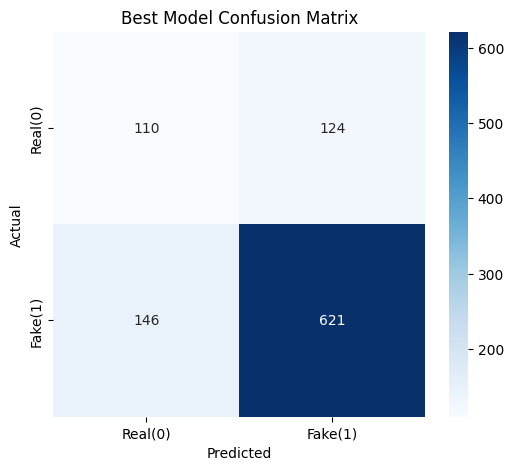

In [ ]:
import copy

epochs = 15
best_auc = -1
best_state = None

for epoch in range(1, epochs+1):
    tr_loss = train_one_epoch(model, train_loader)
    acc, auc, f1 = evaluate(model, test_loader, threshold=0.5)

    print(f"[{epoch}/{epochs}] loss={tr_loss:.4f} | acc={acc:.4f} auc={auc:.4f} f1={f1:.4f}")

    # AUC 기준 best 저장 (원하면 f1 기준으로 바꿔도 됨)
    if not np.isnan(auc) and auc > best_auc:
        best_auc = auc
        best_state = copy.deepcopy(model.state_dict())

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, "/content/drive/MyDrive/xception_fakedet_best2.pt")
    print("Saved best model to:", "/content/drive/MyDrive/xception_fakedet_best2.pt")

model.load_state_dict(torch.load("/content/drive/MyDrive/xception_fakedet_best2.pt")) # 가장 좋았던 모델 로드
all_probs, all_y = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).squeeze(1)
        all_probs.append(torch.sigmoid(logits).cpu().numpy())
        all_y.append(y.numpy())

all_y = np.concatenate(all_y)
all_preds = (np.concatenate(all_probs) >= 0.5).astype(int)

plot_confusion_matrix(all_y, all_preds, title="Best Model Confusion Matrix")

## **주파수 특징 추출**

In [ ]:
import numpy as np
import cv2

class FrequencyFrameDataset(Dataset):
    def __init__(self, df, transform, img_size=160):
        self.df = df
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def get_fft_feature(self, img_pil):
        # 그레이스케일 변환 후 FFT 수행
        img_gray = np.array(img_pil.convert("L").resize((self.img_size, self.img_size)))
        f = np.fft.fft2(img_gray)
        fshift = np.fft.fftshift(f)
        mag = 20 * np.log(np.abs(fshift) + 1)
        mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        return Image.fromarray(mag)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["img_path"]).convert("RGB")

        # RGB 변환 (3, H, W)
        x_rgb = self.transform(img)

        # FFT 변환 및 텐서화 (1, H, W)
        fft_img = self.get_fft_feature(img)
        x_fft = T.ToTensor()(fft_img)

        # 4채널 결합
        x = torch.cat([x_rgb, x_fft], dim=0)
        y = torch.tensor(row["label"], dtype=torch.float32)
        return x, y

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda"):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_probs, all_y = [], []
    for x, y in loader:
        x = x.to(device)
        with torch.amp.autocast("cuda"):
            logits = model(x).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.numpy())

    all_probs = np.concatenate(all_probs)
    all_y = np.concatenate(all_y)
    preds = (all_probs >= 0.5).astype(int)

    acc = accuracy_score(all_y, preds)
    auc = roc_auc_score(all_y, all_probs) if len(np.unique(all_y)) > 1 else 0.5
    f1 = f1_score(all_y, preds, zero_division=0)
    return acc, auc, f1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real(0)', 'Fake(1)'],
                yticklabels=['Real(0)', 'Fake(1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # 1. Loss Graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Metrics Graph (AUC & Acc)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['auc'], 'r-', label='Val AUC')
    plt.plot(epochs, history['acc'], 'g-', label='Val Acc')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/5] Loss: 0.0665 | ACC: 0.7093 | AUC: 0.6041 | F1: 0.8064
Epoch [2/5] Loss: 0.0723 | ACC: 0.6464 | AUC: 0.6364 | F1: 0.7424
Epoch [3/5] Loss: 0.0713 | ACC: 0.7083 | AUC: 0.6604 | F1: 0.8189
Epoch [4/5] Loss: 0.0637 | ACC: 0.6464 | AUC: 0.6018 | F1: 0.7559
Epoch [5/5] Loss: 0.0518 | ACC: 0.6763 | AUC: 0.6038 | F1: 0.7849


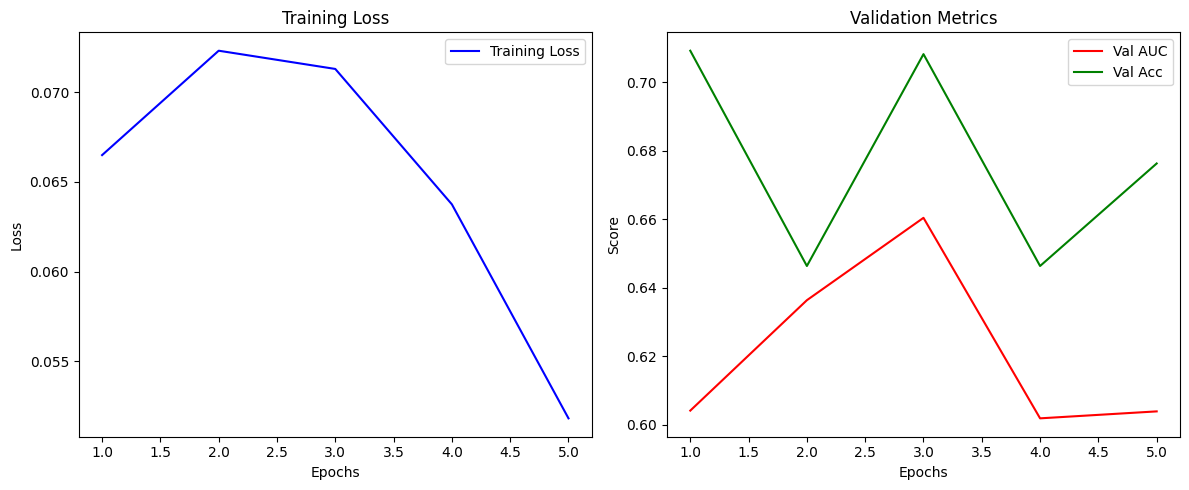

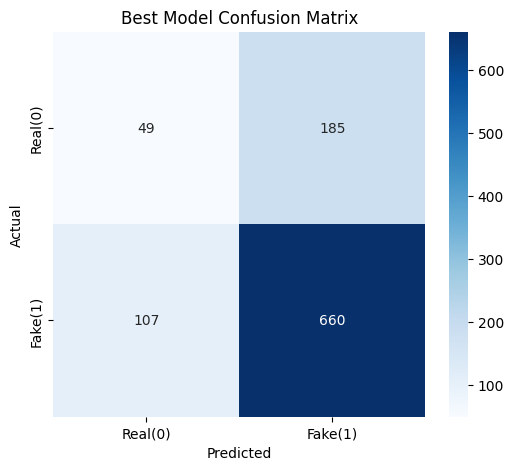

In [ ]:
# 1. 이력 저장용 딕셔너리
history = {'loss': [], 'acc': [], 'auc': [], 'f1': []}
best_auc = 0

for epoch in range(1, epochs + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    acc, auc, f1 = evaluate(model, test_loader)

    # 이력 기록
    history['loss'].append(tr_loss)
    history['acc'].append(acc)
    history['auc'].append(auc)
    history['f1'].append(f1)

    print(f"Epoch [{epoch}/{epochs}] Loss: {tr_loss:.4f} | ACC: {acc:.4f} | AUC: {auc:.4f} | F1: {f1:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "best_model.pt")

# --- 모든 학습 종료 후 결과 시각화 ---

# 1. 학습 곡선 출력
plot_training_history(history)

# 2. 최종 모델(또는 Best 모델)의 Confusion Matrix 출력
model.load_state_dict(torch.load("best_model.pt")) # 가장 좋았던 모델 로드
all_probs, all_y = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).squeeze(1)
        all_probs.append(torch.sigmoid(logits).cpu().numpy())
        all_y.append(y.numpy())

all_y = np.concatenate(all_y)
all_preds = (np.concatenate(all_probs) >= 0.5).astype(int)

plot_confusion_matrix(all_y, all_preds, title="Best Model Confusion Matrix")

FP가 너무 높음

손실함수 -> pos_weight, 최적 claas_weight

xception의 입력 채널 -> convolution layer 수정

In [ ]:
model = timm.create_model("xception", pretrained=True, num_classes=1)
model = model.to(device)

In [ ]:
import numpy as np
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch

class FrequencyFrameDataset(Dataset):
    def __init__(self, df, transform, img_size=160):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def get_fft_feature(self, img_pil):
        # gray float [0,1]
        img_gray = np.array(
            img_pil.convert("L").resize((self.img_size, self.img_size)),
            dtype=np.float32
        ) / 255.0

        f = np.fft.fft2(img_gray)
        fshift = np.fft.fftshift(f)

        # 안정적인 로그 스케일
        mag = np.log1p(np.abs(fshift))

        # 표준화 -> 0~1 스케일
        mag = (mag - mag.mean()) / (mag.std() + 1e-6)
        mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-6)

        mag_u8 = (mag * 255).astype(np.uint8)
        return Image.fromarray(mag_u8)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["img_path"]).convert("RGB")

        x_rgb = self.transform(img)          # (3,H,W)
        fft_img = self.get_fft_feature(img)
        x_fft = T.ToTensor()(fft_img)        # (1,H,W)

        x = torch.cat([x_rgb, x_fft], dim=0) # (4,H,W)
        y = torch.tensor(row["label"], dtype=torch.float32)
        return x, y


In [ ]:
import torch.nn as nn
import torch

def patch_xception_conv1_to_4ch(model):
    old = model.conv1  # Conv2d(3,32,...)

    new = nn.Conv2d(
        in_channels=4,
        out_channels=old.out_channels,
        kernel_size=old.kernel_size,
        stride=old.stride,
        padding=old.padding,
        bias=(old.bias is not None)
    )

    with torch.no_grad():
        # 기존 RGB 3채널 가중치 그대로 복사
        new.weight[:, :3] = old.weight
        # 4번째(FFT) 채널은 RGB 평균으로 초기화
        new.weight[:, 3:4] = old.weight.mean(dim=1, keepdim=True)

        if old.bias is not None:
            new.bias.copy_(old.bias)

    model.conv1 = new
    return model


In [ ]:
import torch
import torch.nn as nn

def make_criterion_with_pos_weight(train_df, device):
    n_pos = int((train_df["label"] == 1).sum())  # Fake(1)
    n_neg = int((train_df["label"] == 0).sum())  # Real(0)

    pos_weight = torch.tensor([n_neg / max(n_pos, 1)], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    return criterion, float(pos_weight.item())


In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    total_loss = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda"):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)

def find_best_threshold(y_true, probs):
    ts = np.linspace(0.05, 0.95, 91)
    best_t, best_f1 = 0.5, -1.0
    for t in ts:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

@torch.no_grad()
def evaluate(model, loader, device, use_best_threshold=True):
    model.eval()
    all_probs, all_y = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        with torch.amp.autocast("cuda"):
            logits = model(x).squeeze(1)
            probs = torch.sigmoid(logits).float().cpu().numpy()

        all_probs.append(probs)
        all_y.append(y.numpy())

    all_probs = np.concatenate(all_probs)
    all_y = np.concatenate(all_y)

    auc = roc_auc_score(all_y, all_probs) if len(np.unique(all_y)) > 1 else 0.5

    if use_best_threshold:
        best_t, best_f1 = find_best_threshold(all_y, all_probs)
        preds = (all_probs >= best_t).astype(int)
        acc = accuracy_score(all_y, preds)
        return acc, auc, best_f1, best_t, all_y, all_probs, preds
    else:
        preds = (all_probs >= 0.5).astype(int)
        acc = accuracy_score(all_y, preds)
        f1 = f1_score(all_y, preds, zero_division=0)
        return acc, auc, f1, 0.5, all_y, all_probs, preds


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real(0)', 'Fake(1)'],
                yticklabels=['Real(0)', 'Fake(1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['auc'], 'r-', label='Val AUC')
    plt.plot(epochs, history['acc'], 'g-', label='Val Acc')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
print("conv1 in_channels:", model.conv1.in_channels)

conv1 in_channels: 4


pos_weight = 0.2234848439693451


/tmp/ipython-input-1165802648.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch [1/15] Loss: 0.1770 | ACC: 0.7662 | AUC: 0.4767 | F1: 0.8657 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/15] Loss: 0.1223 | ACC: 0.7243 | AUC: 0.5377 | F1: 0.8296 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/15] Loss: 0.0938 | ACC: 0.7443 | AUC: 0.4921 | F1: 0.8510 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/15] Loss: 0.0806 | ACC: 0.7632 | AUC: 0.5405 | F1: 0.8600 | best_t: 0.06


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/15] Loss: 0.0734 | ACC: 0.7502 | AUC: 0.4931 | F1: 0.8545 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/15] Loss: 0.0524 | ACC: 0.7652 | AUC: 0.5143 | F1: 0.8609 | best_t: 0.06


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/15] Loss: 0.0445 | ACC: 0.7393 | AUC: 0.5135 | F1: 0.8427 | best_t: 0.06


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/15] Loss: 0.0498 | ACC: 0.6853 | AUC: 0.5379 | F1: 0.8018 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/15] Loss: 0.0579 | ACC: 0.7483 | AUC: 0.5688 | F1: 0.8478 | best_t: 0.08


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [10/15] Loss: 0.0455 | ACC: 0.6813 | AUC: 0.5141 | F1: 0.7987 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [11/15] Loss: 0.0441 | ACC: 0.7123 | AUC: 0.5124 | F1: 0.8240 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [12/15] Loss: 0.0586 | ACC: 0.6973 | AUC: 0.5166 | F1: 0.8135 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [13/15] Loss: 0.0427 | ACC: 0.7522 | AUC: 0.5126 | F1: 0.8548 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [14/15] Loss: 0.0404 | ACC: 0.7353 | AUC: 0.5713 | F1: 0.8355 | best_t: 0.05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [15/15] Loss: 0.0327 | ACC: 0.7353 | AUC: 0.5264 | F1: 0.8405 | best_t: 0.05


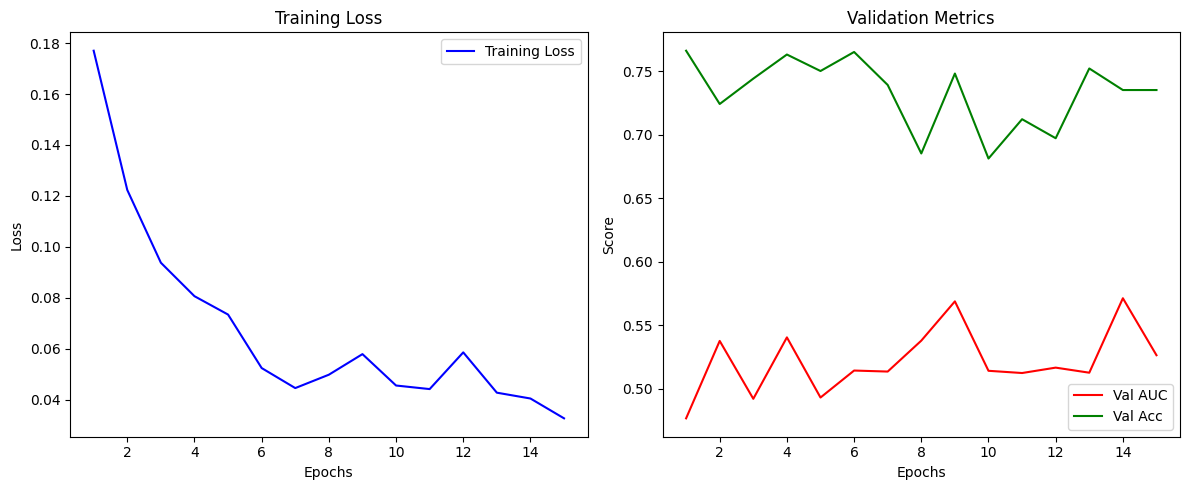

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


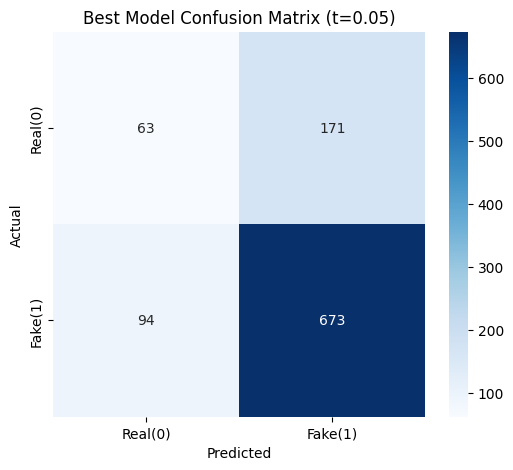

Best AUC: 0.571290074549527 | Best threshold: 0.05


In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"

# transform 예시 (네가 쓰던 normalize 있으면 유지해도 됨)
transform = T.Compose([
    T.Resize((160, 160)),
    T.ToTensor(),
    # T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])  # RGB만 normalize 쓰는 경우가 많음
])

train_ds = FrequencyFrameDataset(train_df, transform=transform, img_size=160)
test_ds  = FrequencyFrameDataset(test_df,  transform=transform, img_size=160)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# ---- 모델 준비 ----
model = patch_xception_conv1_to_4ch(model)
model = model.to(device)

# ---- loss / optim / scaler ----
criterion, pw = make_criterion_with_pos_weight(train_df, device)
print("pos_weight =", pw)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

epochs = 15
history = {'loss': [], 'acc': [], 'auc': [], 'f1': [], 'best_t': []}
best_auc = -1

for epoch in range(1, epochs + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    acc, auc, f1, best_t, y_true, probs, preds = evaluate(model, test_loader, device, use_best_threshold=True)

    history['loss'].append(tr_loss)
    history['acc'].append(acc)
    history['auc'].append(auc)
    history['f1'].append(f1)
    history['best_t'].append(best_t)

    print(f"Epoch [{epoch}/{epochs}] "
          f"Loss: {tr_loss:.4f} | ACC: {acc:.4f} | AUC: {auc:.4f} | F1: {f1:.4f} | best_t: {best_t:.2f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "best_model.pt")

plot_training_history(history)

# Best 모델로 confusion matrix
model.load_state_dict(torch.load("best_model.pt", map_location=device))
acc, auc, f1, best_t, y_true, probs, preds = evaluate(model, test_loader, device, use_best_threshold=True)
plot_confusion_matrix(y_true, preds, title=f"Best Model Confusion Matrix (t={best_t:.2f})")
print("Best AUC:", best_auc, "| Best threshold:", best_t)
